In [ ]:
pip install torch torchvision matplotlib


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])

# Load train dataset only (we'll use it for unsupervised learning with GAN)
batch_size = 128
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 233kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 4.29MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.95MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_dim=784):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Hyperparameters
noise_dim = 100
learning_rate = 0.0002
num_epochs = 50

# Initialize models
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)


In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        # Prepare real and fake labels
        real_images = real_images.view(-1, 784).to(device)
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        # Real images
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)  # Try to fool the discriminator
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")


Epoch [1/50], d_loss: 0.7031, g_loss: 3.6462
Epoch [2/50], d_loss: 0.1326, g_loss: 3.9594
Epoch [3/50], d_loss: 0.6962, g_loss: 3.3380
Epoch [4/50], d_loss: 0.2036, g_loss: 4.8837
Epoch [5/50], d_loss: 0.4679, g_loss: 4.2706
Epoch [6/50], d_loss: 0.4576, g_loss: 2.5654
Epoch [7/50], d_loss: 0.7457, g_loss: 3.5531
Epoch [8/50], d_loss: 0.3328, g_loss: 3.7076
Epoch [9/50], d_loss: 0.5167, g_loss: 2.4942
Epoch [10/50], d_loss: 0.6486, g_loss: 2.4043
Epoch [11/50], d_loss: 0.6233, g_loss: 2.0489
Epoch [12/50], d_loss: 0.8300, g_loss: 1.8347
Epoch [13/50], d_loss: 1.0266, g_loss: 1.8754
Epoch [14/50], d_loss: 0.6038, g_loss: 2.3318
Epoch [15/50], d_loss: 0.7687, g_loss: 2.1744
Epoch [16/50], d_loss: 0.7142, g_loss: 2.2746
Epoch [17/50], d_loss: 0.7973, g_loss: 2.0092
Epoch [18/50], d_loss: 1.2250, g_loss: 1.7378
Epoch [19/50], d_loss: 0.6367, g_loss: 1.6490
Epoch [20/50], d_loss: 0.7200, g_loss: 2.0041
Epoch [21/50], d_loss: 0.7033, g_loss: 1.2487
Epoch [22/50], d_loss: 0.9156, g_loss: 2.01

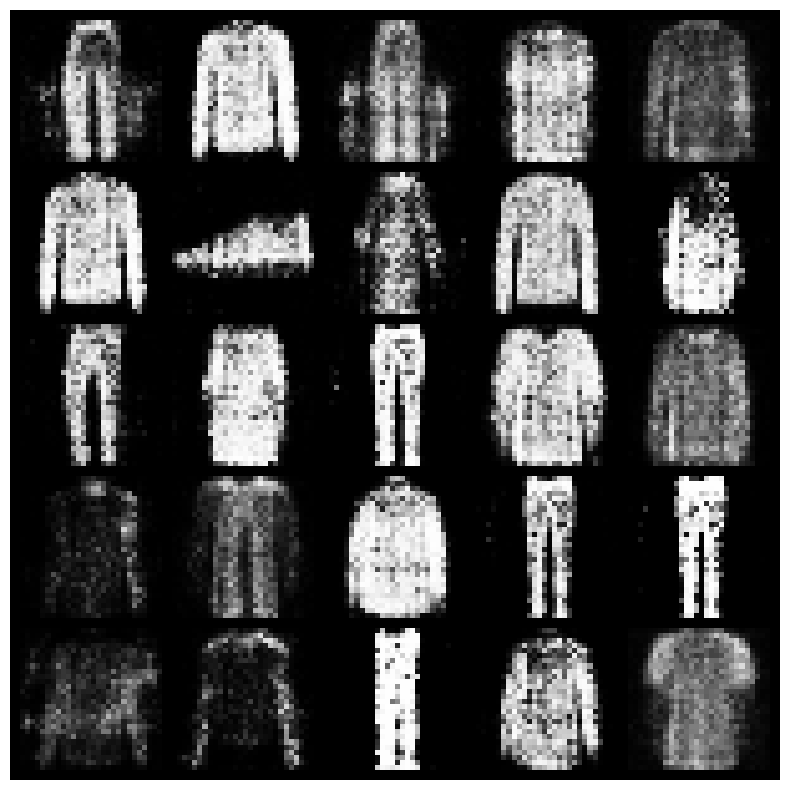

In [ ]:
def generate_images(generator, num_images=25, noise_dim=100):
    noise = torch.randn(num_images, noise_dim).to(device)
    fake_images = generator(noise).view(-1, 1, 28, 28)
    return fake_images

# Generate images
generator.eval()
fake_images = generate_images(generator)
fake_images = fake_images.cpu().detach()
grid = make_grid(fake_images, nrow=5, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.show()
